In [1]:
import os
os.chdir('..')

In [2]:
from jack.readers.implementations import reader_from_file
from jack.io.load import *
import tensorflow as tf
import holoviews as hv
hv.extension('bokeh')

/usr/lib64/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


ModuleNotFoundError: No module named 'holoviews'

In [ ]:
ds = load_squad('data/SQuAD/dev-v1.1.json')
#ds = load_jack('data/qamr/dev.jack.json')

In [4]:
tf.reset_default_graph()
#fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/assoc10_unsup003_tanh'
#fn = '/home/diwe01/fusessh/jtr/triviaqa_wiki/noninteractive/multi_rep/pretrained_squad/segm'
#fn = '/home/diwe01/fusessh/jtr/qamr/noninteractive/multirep'
r = reader_from_file(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/assoc10_unsup003_tanh/model_module


INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/assoc10_unsup003_tanh/model_module


In [80]:
import random

index = random.randint(0, len(ds) - 1)
#index = 7716  # good score example
#index=7716
qa = ds[index]
answers = r([qa[0]])
print(qa[0].question)
print(qa[0].support[0])
print()
print(answers[0][0].text)
correct_answers = set([a.text for a in qa[1]])
print(correct_answers)

What are individual?
Often founded by individual pastors , they have little affiliation with historic denominations .

affiliation with historic denominations
{'pastors'}


In [134]:
#fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/assoc10_unsup003_256/'
#fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/experimental/assoc10_stopgrad_presegm_unsup003'
r.load(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/assoc10_alt_tanh/model_module


INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/assoc10_alt_tanh/model_module


In [5]:
g = tf.get_default_graph()
address_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('assoc_probs')][0]
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]
address_probs_q = [op.outputs[0] for op in g.get_operations() if op.name.endswith('assoc_probs')][1]
frame_boundary_q = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][1]
segm_probs_q = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][1]
attention_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('question_attention_weights')][0]

start_word_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('end_word_score')][0]
start_ngram_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('end_ngram_score')][0]
start_segm_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('end_segm_score')][0]
frames_score = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frames_score')][0]

num_roles = r.shared_resources.config['num_slots']
assoc_scores = [[op.outputs[0] for op in g.get_operations() if op.name.endswith('assoc_' + str(i))][0] for i in range(num_roles)]


all_scores = [start_word_score, start_ngram_score, start_segm_score, frames_score]
all_structure = [address_probs, frame_boundary, segm_probs, address_probs_q, frame_boundary_q, segm_probs_q, attention_probs]

In [6]:
from jack.core.tensorport import Ports
from jack.readers.extractive_qa.shared import XQAPorts

answer_span_tensor = r.model_module.tensors[XQAPorts.span_prediction]


def process(index):
    ex = ds[index]
    batch = r.input_module([ex[0]])
    words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]
    question = [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]]
    tensors = r.session.run(all_scores + all_structure + [answer_span_tensor] + assoc_scores, feed_dict=r.model_module.convert_to_feed_dict(batch))
    ws, ns, ss, fs, ap, fp, wp, apq, fpq, wpq, attnq, answer_span = tensors[:12]
    
    doc_idx = answer_span[0, 0]

    return {
        'question_ws': [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]],
        'support_ws': [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][doc_idx]],
        's_word': ws[doc_idx], 
        's_ngram': ns[doc_idx],
        's_segm': ss[doc_idx], 
        's_frame': fs[doc_idx],
        's_assoc': sum(tensors[12:])[doc_idx] / num_roles,
        'p_slot': ap[doc_idx], 
        'p_frame': fp[doc_idx], 
        'p_segm': wp[doc_idx],
        'p_slot_q': apq[0], 
        'p_frame_q': fpq[0], 
        'p_segm_q': wpq[0],
        'p_attn_q': attnq[0],
        'question': ex[0].question,
        'answers': ex[1],
        'predicted_span': answer_span[0,1:],
    }
        
    
def idxstrseq(l):
    return [w + '   ' + str(i) for i, w in enumerate(l)]

In [7]:
import random

index = random.randint(0, len(ds) - 1)
#index = 7716  # good score example
#index=7716

data = process(index)
print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)

What three things are needed for construction to take place?
design , and financing [69 72]
{'planning,[citation needed] design, and financing', 'planning,[citation needed] design, and financing and continues until the project is built'}


In [8]:
%%opts HeatMap.S [tools=['hover'] colorbar=False width=10*len(data['support_ws'])+50 toolbar='above' xrotation=90 show_title=False]
%%opts HeatMap.S.Segments [height=200] (cmap='Reds')
%%opts HeatMap.S.Scores [height=220]
%%opts HeatMap.S.Assoc [height=220] (cmap='Reds')
%%opts HeatMap.Q [tools=['hover'] colorbar=False width=15*len(data['question_ws'])+50 toolbar='above' xrotation=90 show_title=False] (cmap='Reds')
%%opts HeatMap.Q.Segments [height=200]
%%opts HeatMap.Q.Assoc [height=220]

import numpy as np


def norm(s):
    maxx = np.max(s, 1, keepdims=True)
    minn = np.min(s, 1, keepdims=True)
    return (s - (maxx + minn) / 2) / (maxx - minn) * 2.0

print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)


hm_scores = hv.HeatMap((idxstrseq(data['support_ws']), ['w', 'n', 'p', 'c', 'r'],
                        norm(np.stack([data['s_word'], data['s_ngram'], data['s_segm'], data['s_frame'], data['s_assoc']], 0))),
                       group='S', label='Scores', kdims=['Tokens', 'Scores'])

q_strucutre_values = np.transpose(np.concatenate([data['p_attn_q'], data['p_segm_q'], data['p_frame_q'] * data['p_segm_q']], 1))
hm_question = hv.HeatMap((idxstrseq(data['question_ws']), list(range(q_strucutre_values.shape[0])), q_strucutre_values),
                       group='Q', label='Segments', kdims=['Tokens', 'Probs'])


strucutre_values = np.transpose(np.concatenate([data['p_segm'], data['p_segm'] * data['p_frame']], 1))
hm_support = hv.HeatMap((idxstrseq(data['support_ws']), list(range(strucutre_values.shape[0])), strucutre_values),
                       group='S', label='Segments', kdims=['Tokens', 'Probs'])

hm_assoc = hv.HeatMap((idxstrseq(data['support_ws']), list(range(data['p_slot'].shape[1])), np.transpose(data['p_slot'])),
                       group='S', label='Assoc', kdims=['Tokens', 'Probs'])
    
(hm_scores + hm_question + hm_support + hm_assoc).cols(1)

What three things are needed for construction to take place?
design , and financing [69 72]
{'planning,[citation needed] design, and financing', 'planning,[citation needed] design, and financing and continues until the project is built'}


/usr/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Layout
   .S.Scores   :HeatMap   [Tokens,Scores]   (z)
   .Q.Segments :HeatMap   [Tokens,Probs]   (z)
   .S.Segments :HeatMap   [Tokens,Probs]   (z)
   .S.Assoc    :HeatMap   [Tokens,Probs]   (z)

In [120]:
np.median(data['s_frame'], 0, keepdims=True)

array([0.11656535], dtype=float32)

In [148]:
(np.max(data['s_frame'], 0, keepdims=True) - np.min(data['s_frame'], 0, keepdims=True)) / 2

array([ 2.12374926], dtype=float32)

In [101]:
r.load(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/qamr/noninteractive/multirep/model_module


INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/qamr/noninteractive/multirep/model_module


In [5]:
g = tf.get_default_graph()
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
#frame_attn = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_attn')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]

In [52]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

rp, wp, fattn = r.session.run([frame_boundary, segm_probs, frame_attn], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(20, 2))

#sns.heatmap(np.transpose(wp[0, :100]), xticklabels=words[:100], cmap="Blues", vmax=1.0, vmin=0.0)#, ax=axs[0])
sns.heatmap(np.transpose(np.concatenate([fattn[0], rp[0] * wp[0], wp[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)
#sns.heatmap(np.transpose(rp[0, :50]), xticklabels=words[:50], cmap="Blues", ax=axs[1])

7089


NameError: name 'frame_attn' is not defined

4659


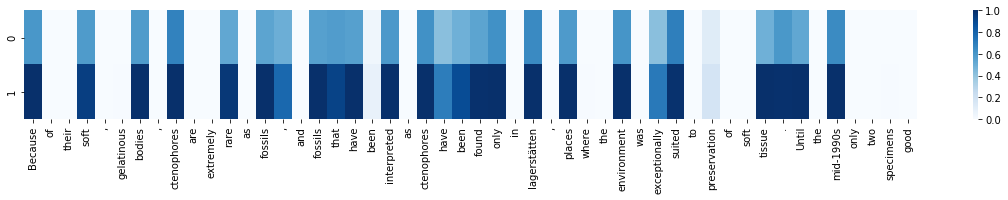

In [11]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)
frame_boundary = [op.outputs[0] for op in g.get_operations() if op.name.endswith('frame_probs')][0]
segm_probs = [op.outputs[0] for op in g.get_operations() if op.name.endswith('segm_probs')][0]

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

rp, wp = r.session.run([frame_boundary, segm_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(20, 2))

#sns.heatmap(np.transpose(wp[0, :100]), xticklabels=words[:100], cmap="Blues", vmax=1.0, vmin=0.0)#, ax=axs[0])
sns.heatmap(np.transpose(np.concatenate([rp[0] * wp[0], wp[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)
#sns.heatmap(np.transpose(rp[0, :50]), xticklabels=words[:50], cmap="Blues", ax=axs[1])

In [137]:
from collections import defaultdict

start_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
end_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
phrases_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
for i in range(1000):
    index = random.randint(0, len(ds) - 1)
    batch = r.input_module([q for q, a in ds[index:index + 1]])
    words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]
    start_word = 0
    ap, rp, wp = r.session.run([address_probs, frame_boundary, segm_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))
    for j, w in enumerate(words):
        for s in range(r.shared_resources.config['num_slots']):
            if ap[0, j, s] > 0.8 and wp[0, j, 0] > 0.5:
                start_word_per_slot[s][words[start_word]] += 1
                end_word_per_slot[s][w] += 1
                phrases_per_slot[s][" ".join(words[start_word:j+1])] += 1
        if wp[0, j, 0] > 0.5 and j+1 < len(words):
            start_word = j+1
                


In [138]:
for i, ps in enumerate(phrases_per_slot):
    print()
    print(i, ', '.join(random.sample([p for p, n in ps.items()], min(len(ps), 10))))
    #print(i)
    #for p, n in sorted(ps.items(), key=lambda x: -x[1])[:5]:
     #   print(p, n)
        

#phrases_per_slot[0]


0 built, painted, affected, developed, peak, held, of seats, him, was instrumental, beaten

1 The Private Education Student Financial Assistance, The Vistula River, at the Santa Clara Convention Center, enjoy, Davis, This imagery, through the Upper Rhine Plain, Lead fusible, To, and " Hell Bent

2 , Ethiopia, can, also, in his response, appointed, still, produced, are, settled, hearing

3 into, between Israel and Syria, Tesla ' s theories, in broadcasting, and Europeans, with, the EU, to Asia, in Latin America, to the museum

4 

5 of the Teaching Council Act 2001, over the last 100 years, in 2011 and 2012, in 1751, until July, in the US, until 1349, During the war, since 1996, every three years

6 often, aimed, course, returning, their, but was, not, , shows, first, its leader

7 Greater London

8 com, and James Lofton, and New York, ., Tadeusz Łempicki

9 established, suffered, recurred, had, eventually, were, remained, have, also, and debuted


5272


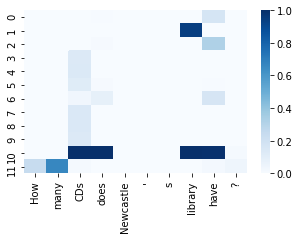

In [87]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
#index = 9154 # Where
print(index)
batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]]

fig, axs = plt.subplots(nrows=1, figsize=(5,3))
ap, attn, wp = r.session.run([address_probs_q, attention_probs, segm_probs_q], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

sns.heatmap(np.transpose(np.concatenate([ap[0]*wp[0], wp[0], attn[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmin=0.0)#, ax=axs[0])


In [63]:
from collections import defaultdict

start_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
end_word_per_slot = [defaultdict(int) for _ in range(r.shared_resources.config['num_slots'])]
phrases_per_slot = [[] for _ in range(r.shared_resources.config['num_slots'])]
attn_heads_per_slot = [[] for _ in range(r.shared_resources.config['num_slots'])]
for i in range(1000):#len(ds)):
    index = random.randint(0, len(ds) - 1)
    batch = r.input_module([q for q, a in ds[index:index + 1]])
    words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.question_words][0]]
    start_word = 0
    ap, attn, wp = r.session.run([address_probs_q, attention_probs, segm_probs_q], feed_dict=r.model_module.convert_to_feed_dict(batch))
    max_attn = np.max(attn, )
    for j, w in enumerate(words):
        for s in range(r.shared_resources.config['num_slots']):
            if ap[0, j, s] > 0.5 and wp[0, j, 0] > 0.8:
                start_word_per_slot[s][words[start_word]] += 1
                end_word_per_slot[s][w] += 1
                phrases_per_slot[s].append(" ".join(words[start_word:j+1]))
                if attn[0, j] == max_attn:
                    attn_heads_per_slot[s].append(" ".join(words[start_word:j+1]))
        if wp[0, j, 0] > 0.8 and j+1 < len(words):
            start_word = j+1


In [64]:
from collections import Counter

for i, ps in enumerate(attn_heads_per_slot):
    ct = Counter()
    for p in ps:
        ct[p] += 1

    print(i, '&', ', '.join("%s (%d)" % (p, n) for p, n in sorted(ct.items(), key=lambda x: -x[1])[:5]), ' &  \\\\')
    

0 & What ranking (2), Where (1), court (1), During which period (1), by Shelley what (1)  &  \\
1 & in which area (1), neighborhood (1)  &  \\
2 & rank (1), given (1), , when (1), is the ranking (1), where (1)  &  \\
3 &   &  \\
4 &   &  \\
5 & from which sport (1), other city (1)  &  \\
6 & was the ratio (1), was the number (1), company (1), game (1), , what (1)  &  \\
7 &   &  \\
8 &   &  \\
9 & What team (1), Who (1)  &  \\


8087


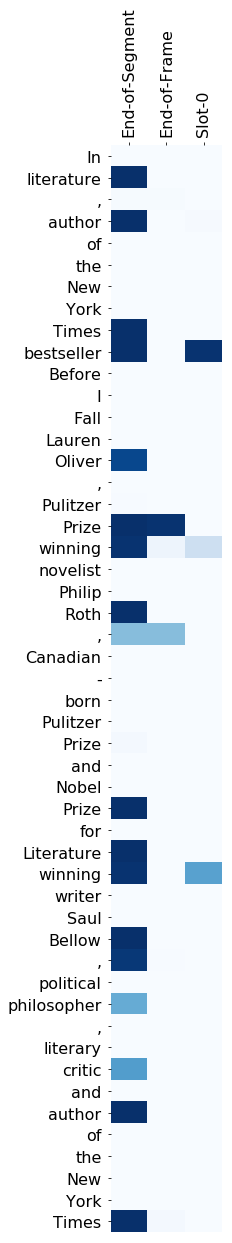

In [94]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)

sns.set_context("paper", font_scale=2, rc={"axes.labelposition": "top"})


batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

rp, wp, ap = r.session.run([frame_boundary.outputs[0], segm_probs.outputs[0], address_probs.outputs[0]], feed_dict=r.model_module.convert_to_feed_dict(batch))

#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(2 + ap.shape[2] // 2,20))


#sns.heatmap(np.transpose(wp[0, :100]), xticklabels=words[:100], cmap="Blues", vmax=1.0, vmin=0.0)#, ax=axs[0])
g = sns.heatmap(np.concatenate([wp[0], rp[0] * wp[0], ap[0]], 1)[:50], 
                yticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0, cbar=False)

g.set_xticklabels(['End-of-Segment', 'End-of-Frame'] + ['Slot-%d' % i for i in range(ap.shape[2])], rotation=90)
g.xaxis.tick_top()
g.xaxis.set_label_position('top')


#sns.heatmap(np.transpose(rp[0, :50]), xticklabels=words[:50], cmap="Blues", ax=axs[1])

In [90]:
?sns.heatmap

In [86]:
ap.shape

(1, 142, 10)

(array([[ 0.,  2.,  1.,  3.],
        [ 2.,  0.,  4.,  2.],
        [ 4.,  1.,  5.,  1.]]), 25.0)

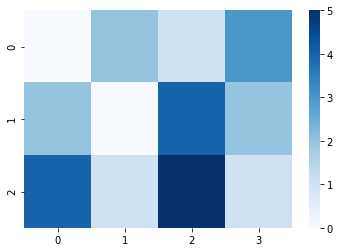

In [38]:
A = np.array([[0.0,2,1,3], [2, 0, 4, 2], [4, 1, 5, 1]])
P = np.ones_like(A) * 1.0 / max(A.shape[0], A.shape[1])
sns.heatmap(A, cmap="Blues")
A, np.sum(A)

(array([  9.99724430e-01,   3.18881637e-07,   9.99936328e-01,
          9.99999681e-01]), array([ 1.        ,  0.99966076,  1.        ]))

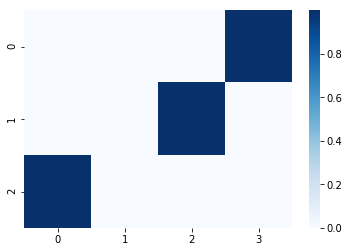

In [393]:
B = P * A
W = B * B / np.sum(A, axis=0, keepdims=True) / np.sum(A, axis=1, keepdims=True)
P = W / np.maximum(np.sum(W, 0, keepdims=True), np.sum(W, 1, keepdims=True))
sns.heatmap(P, cmap="Blues")
np.sum(P, axis=0), np.sum(P, axis=1)

(array([ 0.61363636,  0.42424242,  0.95454545,  0.84090909]),
 array([ 0.93333333,  0.9       ,  1.        ]))

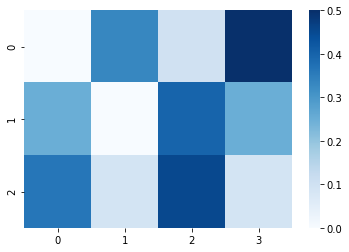

In [385]:
W = P * A
#W = B * B / np.sum(A, axis=0, keepdims=True) / np.sum(A, axis=1, keepdims=True)
P = W / np.maximum(np.sum(W, 0, keepdims=True), np.sum(W, 1, keepdims=True))
sns.heatmap(P, cmap="Blues")
np.sum(P, axis=0), np.sum(P, axis=1)

In [266]:
np.maximum(np.sum(A, 0, keepdims=True), np.sum(A, 1, keepdims=True))

array([[  9.,   8.,  11.,   9.],
       [ 20.,  20.,  20.,  20.],
       [ 11.,  11.,  11.,  11.]])

In [263]:
A1

array([[ 0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.25663196,  0.        ,  0.74336804,  0.        ]])

In [39]:
import tensorflow as tf

In [58]:
A = np.array([[[0.0,2,1,3],
              [2, 0, 4, 2],
              [4, 1, 5, 1],
              [40, 10, 50, 10]],
              [[0.0,2,1,3],
              [2, 0, 4, 2],
              [4, 1, 5, 1],
              [40, 10, 50, 10]]])

r.model_module.tf_session.run(tf.matrix_band_part(A, -1, 0) * (1.0 - tf.expand_dims(tf.eye(tf.shape(A)[1], tf.shape(A)[2], dtype=tf.float64), 0)))

array([[[  0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   0.],
        [  4.,   1.,   0.,   0.],
        [ 40.,  10.,  50.,   0.]],

       [[  0.,   0.,   0.,   0.],
        [  2.,   0.,   0.,   0.],
        [  4.,   1.,   0.,   0.],
        [ 40.,  10.,  50.,   0.]]])

In [3]:
ds = load_squad('data/SQuAD/dev-v1.1.json')

In [50]:
tf.reset_default_graph()
fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/'
r = reader_from_file(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/model_module


In [133]:
fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/'
r.load(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/hierarchical_segm_depth4/model_module


In [122]:
g = tf.get_default_graph()
address_probs = [op for op in g.get_operations() if op.name.endswith('depth_prob')][1]
segm_probs = [op for op in g.get_operations() if op.name.endswith('segm_probs')][1]
pop_probs = [op for op in g.get_operations() if op.name.endswith('pop_probs')][1]
push_probs = [op for op in g.get_operations() if op.name.endswith('push_probs')][1]

3750


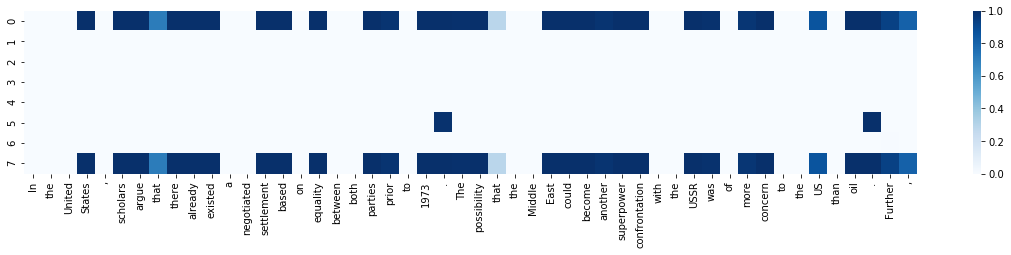

In [178]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from jack.core.tensorport import Ports
import random
index = random.randint(0, len(ds) - 1)
print(index)

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

ap, wp, op, up = r.session.run([address_probs.outputs[0], segm_probs.outputs[0], pop_probs.outputs[0], push_probs.outputs[0]], feed_dict=r.model_module.convert_to_feed_dict(batch))

hard=False

if hard:
    op, up, wp = np.round(op), np.round(up), np.round(wp)

op *= wp
up *= np.concatenate([np.ones([1, 1, 1]), wp[:, :-1]], 1) * (1-op)

fig, axs = plt.subplots(nrows=1, figsize=(20,3))
sns.heatmap(np.transpose(np.concatenate([ap[0] * wp[0],
                                         np.zeros_like(op[0]),
                                         op[0],
                                         up[0],
                                         wp[0]], 1)[:50]),
            xticklabels=words[:50], cmap="Blues", vmin=0.0, vmax=1.0)#, ax=axs[0])
depth = ap.shape[2]
if hard:
    s = ['->']
    d = 0
    for i, w in enumerate(words):
        if up[0, i, 0] > 0.8 and d < depth - 1:
            d = 1
            if not s[-1].startswith('\n'):
                s.append('\n' + '    ' * d + '->')
        if s[-1] == '\n':
            s[-1] += '    ' * d + '->'
        s.append(w)
        if op[0, i, 0] > 0.8:
            #s.append('}')
            if d == 0:
                s.append('\n----------------------------------------------------------------------------------------------------------')
            else:
                d -= 1
            s.append('\n')
        elif wp[0, i, 0] > 0.8:
            s.append('|')
    print(" ".join(s))

In [320]:
address_probs = [list(op for op in g.get_operations() if op.name.endswith('address_probs' + str(i)))[1]
                 for i in range(r.shared_resources.config['num_layers'])]

3809


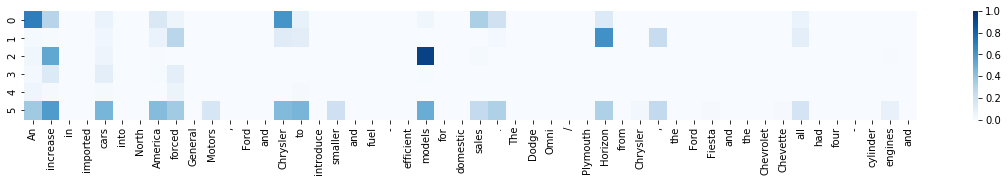

In [328]:
level = 1

index = random.randint(0, len(ds) - 1)
print(index)

batch = r.input_module([q for q, a in ds[index:index + 1]])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

ps = r.session.run([p.outputs[0] for p in segm_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))
ap = r.session.run([p.outputs[0] for p in address_probs], feed_dict=r.model_module.convert_to_feed_dict(batch))
ps = np.cumprod(np.concatenate(ps, 2), 2)
#ap, rp, wp = np.round(ap), np.round(rp), np.round(wp)

fig, ax = plt.subplots(nrows=1, figsize=(20, 2))
#sns.heatmap(np.transpose(np.concatenate(ps, 2)[0, :50, ::-1]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)
sns.heatmap(np.transpose(np.concatenate([ap[level], ps[:,:,level:level+1]], 2)[0, :50]), xticklabels=words[:50], cmap="Blues", vmax=1.0, vmin=0.0)

In [5]:
import spacy
nlp = spacy.load("en")
ds = load_squad('data/SQuAD/dev-v1.1.json')

In [28]:
tf.reset_default_graph()
fn = '/home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/ngram'
r = reader_from_file(fn)

INFO:tensorflow:Restoring parameters from /home/diwe01/fusessh/jtr/squad/noninteractive/multi_rep/ngram/model_module


In [6]:
import random

total = len(da)
num_correct = 0

for index in range(total):
    a = r([q for q, a in ds[index:index + 1]])[0][0]

    support = nlp(ds[index][0].support[0])
    support_sentences = list(support.sents)

    def sentence_idx(idx):
        for i, s in enumerate(support_sentences):
            if s.start_char <= idx and s.end_char >= idx:
                return i

    if sentence_idx(a.span[0]) == sentence_idx(ds[index][1][0].span[0]):
        num_correct += 1

num_correct / total

0.759

In [ ]:
# ngram:           60.9
# segm:            62.0
# frame:           75.0
# assoc10:         
# assoc10_unsup01: 76.2
#
# bilstm 256:      69.0

In [32]:
from jack.util.preprocessing import nlp_preprocess
from jack.util.vocab import Vocab

vocab = Vocab()

def load_conll_srl(path):
    sentences = list()
    all_srls = list()
    srls = None
    current_labels = None
    with open(path, 'r') as f:
        for l in f:
            if l.startswith('#'):
                continue
            if l.strip():
                split = [s for s in l.split(' ') if s]
                if srls is None:
                    srls = [[list()] for _ in range(len(split) - 12)]
                    current_labels = ['*' for _ in range(len(split) - 12)]
                    sentences.append([])
                
                words = nlp_preprocess(split[3].replace('/.', '.'), vocab)[0]
                sentences[-1].extend(words)
                
                for i, s in enumerate(split[11:-1]):
                    if s.startswith("("):
                        current_labels[i] = s[1:s.index('*')]
                        if srls[i][-1]:
                            srls[i].append([])
                    srls[i][-1].extend([current_labels[i]] * len(words))
                    if s.endswith(")"):
                        srls[i].append([])
                        current_labels[i] = '*'
            else:
                all_srls.append(srls)
                srls = None
    for i in range(len(sentences)):
        sentences[i] = ' '.join(sentences[i])
    return sentences, all_srls
    

In [33]:
sentences, srls = load_conll_srl('/run/media/diwe01/Data3/ontonotes-release-5.0/conll-formatted-ontonotes-5.0-12/conll-formatted-ontonotes-5.0/data/development/data/english/annotations/bc/cnn/00/cnn_0000.gold_conll')

(48, 0.2222222222222222)

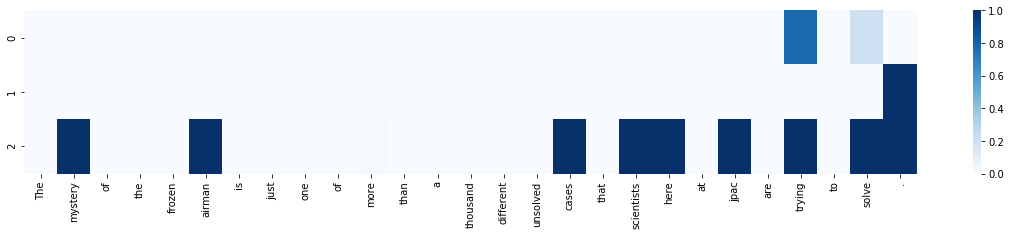

In [34]:
from jack.core.data_structures import QASetting
import numpy as np
from jack.core.tensorport import Ports

idx = random.randint(0, len(sentences)-1)

qa = QASetting('', [sentences[idx]])

batch = r.input_module([qa])
words = [batch['__rev_vocab'][w] for w in batch[Ports.Input.support_words][0]]

ap, rp, wp = r.session.run([address_probs.outputs[0], frame_boundary.outputs[0], segm_probs.outputs[0]], feed_dict=r.model_module.convert_to_feed_dict(batch))

spans = set()
roles = dict()
last = 0
for i, v in enumerate(wp[0,:,0]):
    if v > 0.8:
        spans.add((last, i))
        last = i + 1
        

possible_spans = set()
for srl in srls[idx]:
    offset = 0
    for s in srl:
        possible_spans.add((offset, offset + len(s) - 1))
        offset += len(s)
        

fig, axs = plt.subplots(nrows=1, figsize=(20,3))
sns.heatmap(np.transpose(np.concatenate([ap[0], rp[0] * wp[0], wp[0]], 1)[:50]), xticklabels=words[:50], cmap="Blues", vmin=0.0, vmax=1.0)#, ax=axs[0])

idx, len(spans.intersection(possible_spans)) / len(spans)

In [35]:
possible_spans, spans

({(0, 3),
  (0, 5),
  (0, 16),
  (0, 17),
  (0, 21),
  (4, 4),
  (5, 5),
  (6, 6),
  (6, 26),
  (7, 25),
  (17, 17),
  (18, 21),
  (22, 22),
  (22, 24),
  (23, 23),
  (23, 26),
  (24, 25),
  (25, 25),
  (26, 26)},
 {(0, 1),
  (2, 5),
  (6, 16),
  (17, 18),
  (19, 19),
  (20, 21),
  (22, 23),
  (24, 25),
  (26, 26)})

In [172]:
len(spans.intersection(possible_spans)) / len(spans)

0.7333333333333333

In [150]:
start = 0
end = 30
scores = norm(np.stack([data['s_word'], data['s_ngram'], data['s_segm'], data['s_frame'], data['s_assoc']], 1))[start:end]


In [154]:
%%opts HeatMap.S [fontsize={'ticks': 12, 'title': 12, 'ylabel': 12, 'xlabel': 12} colorbar=False height=20*(end-start)+50 toolbar='above' show_title=False]
%%opts HeatMap.S.Segments [height=240] (cmap='Reds')
%%opts HeatMap.S.Scores [width=300]
%%opts HeatMap.S.Assoc [height=220] (cmap='Reds')

import numpy as np

def norm(s):
    maxx = np.max(s, 1, keepdims=True)
    minn = np.min(s, 1, keepdims=True)
    return (s - (maxx + minn) / 2) / (maxx - minn) * 2.0

print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)

hm_scores = hv.HeatMap((['w', 'n', 'p', 'c', 'r'], idxstrseq(data['support_ws'])[start:end], scores),
                       group='S', label='Scores', kdims=['Scores', 'Tokens'])

hm_scores

Who tackled Mike Tolbert and caused a fumble?
Darian Stewart [16 17]
{'Stewart', 'Darian Stewart'}


:HeatMap   [Scores,Tokens]   (z)

# Example for Paper

In [143]:
import random
import numpy as np

index = 727
data = process(index)
print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)

def norm(s):
    maxx = np.max(s, 1, keepdims=True)
    minn = np.min(s, 1, keepdims=True)
    return (s - (maxx + minn) / 2) / (maxx - minn) * 2.0

start = 0
end = 30
scores = norm(np.stack([data['s_word'], data['s_ngram'], data['s_segm'], data['s_frame'], data['s_assoc']], 0))

scale = 1

Who tackled Mike Tolbert and caused a fumble?
Darian Stewart [16 17]
{'Darian Stewart', 'Stewart'}


In [144]:
%%opts HeatMap.S1 [xaxis=None height=int(scale*130) fontsize={'ticks': int(scale*20), 'ylabel': int(scale*16)} colorbar=False width=int(scale*40*(end-start)+50) toolbar='above' xrotation=90 show_title=False] (cmap='gray_r')
%%opts HeatMap.S2 [height=int(scale*400) fontsize={'ticks': int(scale*20), 'ylabel': int(scale*16), 'xlabel': int(scale*20)} colorbar=True width=int(scale*40*(end-start)+50) toolbar='above' xrotation=90 show_title=False] (cmap='gray_r')


import numpy as np


print(data['question'])
print(' '.join(data['support_ws'][i] for i in range(data['predicted_span'][0], data['predicted_span'][1] + 1)), data['predicted_span'])
correct_answers = set([a.text for a in data['answers']])
print(correct_answers)


hm_scores1 = hv.HeatMap((range(len(data['support_ws'])), ['w', 'n', 'p', 'c', 'r'], scores),
                        group='S1', label='Scores', kdims=['Tokens', 'Scores'])


hm_scores2 = hv.HeatMap((idxstrseq(data['support_ws'])[start:end], ['w', 'n', 'p'], scores[:3, start:end]),
                        group='S2', label='Scores', kdims=['Tokens', 'Scores'])
(hm_scores1 + hm_scores2).cols(1)

Who tackled Mike Tolbert and caused a fumble?
Darian Stewart [16 17]
{'Darian Stewart', 'Stewart'}


/usr/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Layout
   .S1.Scores :HeatMap   [Tokens,Scores]   (z)
   .S2.Scores :HeatMap   [Tokens,Scores]   (z)

In [155]:
labels = ['1/1k', '3/3k', '10/10k', '30/30k', '100/100k', '300/Full']
baseline = [44.3, 50.5, 55.5, 61.9, 68.1, 76.9]
task = [51.8, 55.8, 60.1, 65.0, 70.7, 78.1]
knowledge = [52.4, 57.9, 62.4, 66.6, 71.3, 78.8]

In [160]:
%%opts Curve [height=600 fontsize={'ticks': 20, 'ylabel': 20, 'xlabel': 20, 'legend': 20} width=1000 toolbar='above' show_title=False]

c1 = hv.Curve((labels, baseline),
              hv.Dimension("Pretrained Embedding Reduction/Training Examples"),
              hv.Dimension("Accuracy in %", range=(40, 100)), label="ESIM")
c2 = hv.Curve((labels, task),
              hv.Dimension("Pretrained Embedding Reduction/Training Examples"),
              hv.Dimension("Accuracy in %", range=(40, 100)), label="+ Task Input")

c3 = hv.Curve((labels, knowledge),
              hv.Dimension("Pretrained Embedding Reduction/Training Examples"),
              hv.Dimension("Accuracy in %", range=(40, 100)), label="+ ConceptNet")

c1 * c2 * c3

/usr/lib/python3.6/site-packages/bokeh/core/json_encoder.py:80: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(type(obj), np.float):


:Overlay
   .Curve.ESIM            :Curve   [Pretrained Embedding Reduction/Training Examples]   (Accuracy in %)
   .Curve.Plus_Task_Input :Curve   [Pretrained Embedding Reduction/Training Examples]   (Accuracy in %)
   .Curve.Plus_ConceptNet :Curve   [Pretrained Embedding Reduction/Training Examples]   (Accuracy in %)

In [3]:
from jack.readers.implementations import reader_from_file
from jack.io.load import *
import tensorflow as tf